# Espherical Graph Variational Autoencoder sobre Santiago

**Tarea**: reconstrucción de adyacencia del grafo.
**Loss**: Entropía cruzada binaria con regularización esférica

In [1]:
# Hyperspherical Graph VAE para grafo_santiago_filtrado_con_embeddings.gexf

import os
import math
import random
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import umap

import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

try:
    from torch_geometric.utils import from_networkx, negative_sampling
    from torch_geometric.data import Data
    from torch_geometric.nn import GCNConv
except ImportError as e:
    raise ImportError(
        "Este notebook requiere torch_geometric. "
        "Instala con: pip install torch-geometric (y dependencias según tu sistema)."
    ) from e

from SGVAE import HypersphericalGraphVAE

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

/Users/diegolarraguibel/Desktop/Semestre 2025-2/Aprendizaje en Grafos/github_aprendizaje_grafos/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: mps


In [2]:
GRAPH_PATH = "../data/grafo_santiago_filtrado_con_embeddings.gexf"
G_nx = nx.read_gexf(GRAPH_PATH)

print(f"Nodos: {G_nx.number_of_nodes()}, Aristas: {G_nx.number_of_edges()}")

# 2. Inspeccionar atributos para detectar columnas de embeddings
sample_node = next(iter(G_nx.nodes(data=True)))[1]
print("Atributos de ejemplo de un nodo:\n", sample_node)

# Detectar columnas de embeddings: todas las claves que parezcan A00, A01, ...
emb_keys = sorted([k for k in sample_node.keys() if k.startswith("A")])
if not emb_keys:
    raise ValueError("No se encontraron columnas de embeddings tipo 'e_0, e_1, ...' en los nodos.")

emb_dim = len(emb_keys)
print(f"Detectadas {emb_dim} dimensiones de embedding AE.")

# Detectar tipos de OSM
tipos = set()
for _, data in G_nx.nodes(data=True):
    t = data.get("tipo", None)
    if t is not None:
        tipos.add(str(t))
tipos = sorted(list(tipos))
tipo2idx = {t: i for i, t in enumerate(tipos)}

print(f"Se encontraron {len(tipos)} tipos de POI OSM.")

# 3. Construir matriz de features nodales
num_nodes = G_nx.number_of_nodes()
tipo_dim = len(tipos)

X = np.zeros((num_nodes, tipo_dim + emb_dim), dtype=np.float32)

# Mapear node ids de NetworkX a índice entero 0..N-1
node_id_to_idx = {node_id: i for i, node_id in enumerate(G_nx.nodes())}

missing_tipo = 0
missing_emb = 0

for node_id, data in G_nx.nodes(data=True):
    i = node_id_to_idx[node_id]
    
    # One-hot de tipo
    t = data.get("tipo", None)
    if t is not None and str(t) in tipo2idx:
        tipo_idx = tipo2idx[str(t)]
        X[i, tipo_idx] = 1.0
    else:
        missing_tipo += 1
    
    # Embeddings AE
    emb_vals = []
    for k in emb_keys:
        val = data.get(k, None)
        if val is None:
            emb_vals = None
            break
        try:
            emb_vals.append(float(val))
        except ValueError:
            emb_vals = None
            break
    
    if emb_vals is not None:
        X[i, tipo_dim:] = np.array(emb_vals, dtype=np.float32)
    else:
        missing_emb += 1

print(f"Nodos sin tipo asignado: {missing_tipo}")
print(f"Nodos sin embedding completo: {missing_emb}")

# 4. Crear objeto PyG Data
# Usamos from_networkx y luego reemplazamos x con nuestra matriz
G_tmp = nx.relabel_nodes(G_nx, node_id_to_idx)  # asegurar nodos 0..N-1
data = from_networkx(G_tmp)

# Asegurar que edge_index está bien formateado
edge_index = data.edge_index

# Asignar features
data.x = torch.from_numpy(X)
data.num_nodes = num_nodes

data = data.to(device)
print(data)


Nodos: 29267, Aristas: 303540
Atributos de ejemplo de un nodo:
 {'lat': -33.4395505, 'lon': -70.6511137, 'tipo': 'comercio', 'nombre': 'Lentes Online', 'A00': 0.07759969242599, 'A01': -0.1409747020376778, 'A02': 0.17469219530949634, 'A03': -0.08710003844675125, 'A04': -0.04537331795463283, 'A05': -0.2385051903114187, 'A06': 0.0858722029988466, 'A07': 0.06849796232218378, 'A08': -0.20947512495194157, 'A09': 0.07512187620146098, 'A10': 0.05920430603613995, 'A11': 0.10161507112648982, 'A12': 0.07087489427143406, 'A13': 0.0667435601691657, 'A14': -0.11246874279123414, 'A15': -0.045562783544790465, 'A16': 0.20536347558631296, 'A17': 0.03699746251441753, 'A18': 0.1430957324106113, 'A19': 0.11327581699346405, 'A20': -0.03000938100730488, 'A21': 0.05978254517493272, 'A22': -0.0975920030757401, 'A23': 0.005878354479046518, 'A24': 0.06543452518262206, 'A25': 0.012175009611687812, 'A26': -0.1297371780084583, 'A27': 0.06900484429065744, 'A28': 0.037332103037293354, 'A29': -0.20038815840061516, 'A3

In [3]:
# Edge index completo (sin self loops)
edge_index = data.edge_index
num_nodes = data.num_nodes

# Asegurar que no haya self-loops duplicados
# (optional, por higiene)
mask = edge_index[0] != edge_index[1]
edge_index = edge_index[:, mask]

data.edge_index = edge_index

print("Edges usados:", edge_index.size(1))

# Función auxiliar para muestrear positivos y negativos
def get_pos_neg_edges(edge_index, num_nodes, num_neg=None):
    # Positivos: todas las aristas (o subset si quieres)
    pos_edge_index = edge_index

    if num_neg is None:
        num_neg = pos_edge_index.size(1)

    neg_edge_index = negative_sampling(
        edge_index=pos_edge_index,
        num_nodes=num_nodes,
        num_neg_samples=num_neg,
        method='sparse'
    )

    return pos_edge_index, neg_edge_index


Edges usados: 607080


In [4]:
in_dim = data.x.size(1)
hidden_dim = 256
latent_dim = 64
noise_scale = 0.1
lambda_uniform = 1e-2

model = HypersphericalGraphVAE(
    in_dim=in_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    noise_scale=noise_scale,
    lambda_uniform=lambda_uniform
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

print(model)

num_epochs = 300  # puedes ajustar

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()

    pos_edge_index, neg_edge_index = get_pos_neg_edges(
        data.edge_index, data.num_nodes
    )

    pos_edge_index = pos_edge_index.to(device)
    neg_edge_index = neg_edge_index.to(device)

    loss, recon_loss, reg_uniform, mu, z = model(
        data.x, data.edge_index, pos_edge_index, neg_edge_index
    )

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:03d} | "
            f"Loss: {loss.item():.4f} | "
            f"Recon: {recon_loss.item():.4f} | "
            f"Reg(unif): {reg_uniform.item():.6f}"
        )

print("Entrenamiento finalizado.")


HypersphericalGraphVAE(
  (encoder): HypersphericalGraphEncoder(
    (conv1): GCNConv(73, 256)
    (conv2): GCNConv(256, 64)
  )
)
Epoch 001 | Loss: 0.7055 | Recon: 0.7007 | Reg(unif): 0.485232
Epoch 010 | Loss: 0.5886 | Recon: 0.5879 | Reg(unif): 0.065201
Epoch 020 | Loss: 0.5761 | Recon: 0.5759 | Reg(unif): 0.013156
Epoch 030 | Loss: 0.5736 | Recon: 0.5736 | Reg(unif): 0.002984
Epoch 040 | Loss: 0.5722 | Recon: 0.5722 | Reg(unif): 0.001590
Epoch 050 | Loss: 0.5713 | Recon: 0.5713 | Reg(unif): 0.000761
Epoch 060 | Loss: 0.5707 | Recon: 0.5707 | Reg(unif): 0.000390
Epoch 070 | Loss: 0.5704 | Recon: 0.5704 | Reg(unif): 0.000225
Epoch 080 | Loss: 0.5701 | Recon: 0.5701 | Reg(unif): 0.000122
Epoch 090 | Loss: 0.5696 | Recon: 0.5696 | Reg(unif): 0.000137
Epoch 100 | Loss: 0.5697 | Recon: 0.5697 | Reg(unif): 0.000149
Epoch 110 | Loss: 0.5694 | Recon: 0.5694 | Reg(unif): 0.000147
Epoch 120 | Loss: 0.5691 | Recon: 0.5691 | Reg(unif): 0.000154
Epoch 130 | Loss: 0.5692 | Recon: 0.5692 | Reg(uni

In [5]:
z_np = z.detach().cpu().numpy()
norms = np.linalg.norm(z_np, axis=1, keepdims=True) + 1e-8
z_unit = z_np / norms

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=40,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

z_2d = reducer.fit_transform(z_unit)

/Users/diegolarraguibel/Desktop/Semestre 2025-2/Aprendizaje en Grafos/github_aprendizaje_grafos/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/var/folders/w5/kmvyzkpj2q1fyf7tnn3nqwb40000gn/T/ipykernel_97751/717133316.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_tipos)  # buena paleta categórica


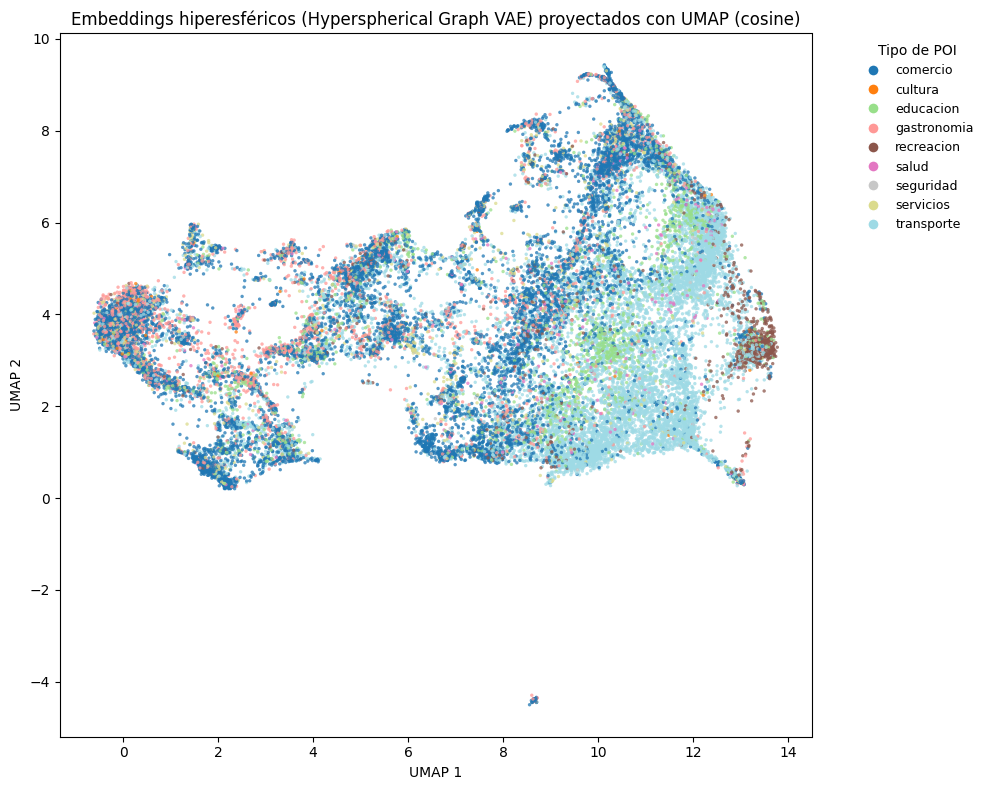

In [6]:
# Construir lista de tipos en el mismo orden de índices usados para z
idx_to_node_id = {i: node_id for node_id, i in node_id_to_idx.items()}

tipos_por_nodo = []
for i in range(len(z_2d)):
    node_id = idx_to_node_id[i]
    t = G_nx.nodes[node_id].get("tipo", "desconocido")
    tipos_por_nodo.append(str(t))

tipos_unicos = sorted(set(tipos_por_nodo))
num_tipos = len(tipos_unicos)

# Colormap
cmap = cm.get_cmap('tab20', num_tipos)  # buena paleta categórica
tipo_to_color = {t: cmap(i) for i, t in enumerate(tipos_unicos)}

colors = np.array([tipo_to_color[t] for t in tipos_por_nodo])

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    z_2d[:, 0],
    z_2d[:, 1],
    c=colors,
    s=6,
    alpha=0.75,
    linewidths=0
)

# Leyenda con colores correctos
handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=t,
        markerfacecolor=tipo_to_color[t],
        markersize=8
    )
    for t in tipos_unicos
]

plt.legend(
    handles=handles,
    title="Tipo de POI",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=False,
    fontsize=9
)

plt.title("Embeddings hiperesféricos (Hyperspherical Graph VAE) proyectados con UMAP (cosine)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()